In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

In [2]:
# transform = transforms.Compose([
#     transforms.ToTensor()])

In [16]:
transform = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [17]:
trainset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
testset = datasets.CIFAR10(root="./data",train=False,transform=transform,download=True)

In [41]:
batch_size = 4
train_dataloader = DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

In [42]:
classes = trainset.classes

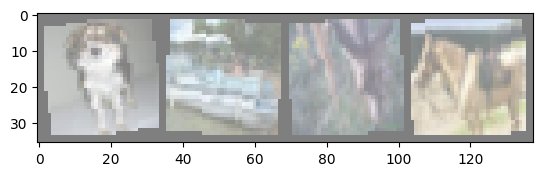

dog   ship  deer  horse


In [20]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


In [21]:
images[0].shape

torch.Size([3, 32, 32])

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CifCNN(nn.Module):
    def __init__(self):
        super(CifCNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 6, 5),        # input: 3 channels (RGB), output: 6 feature maps
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(6, 16, 5),       # FIXED: should take 6 input channels, not 3
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), # CIFAR10 images are 32x32, works out to 5x5 after pooling
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, inp):
        logits = self.layers(inp)
        return logits


In [44]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else "cpu"
model = CifCNN().to(device)
print(model)

CifCNN(
  (layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [45]:
from torch import optim

In [46]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=1e-3,momentum=0.9)

In [47]:
# Training Network
epochs = 5


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for _, data in enumerate(train_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # forward pass
        out = model(images)
        loss = criterion(out, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"{epoch+1}/{epochs}\t Loss: {running_loss}")
    model.eval()
    correct , total = 0, 0

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, pred = torch.max(outputs, 1)

            total += labels.size(0)
            correct+= (labels == pred).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

1/5	 Loss: 23155.707929700613
Accuracy of the network on the 10000 test images: 43 %
2/5	 Loss: 18610.147414311767
Accuracy of the network on the 10000 test images: 48 %
3/5	 Loss: 17226.66496795416
Accuracy of the network on the 10000 test images: 53 %
4/5	 Loss: 16335.551332637668
Accuracy of the network on the 10000 test images: 53 %
5/5	 Loss: 15707.44439072162
Accuracy of the network on the 10000 test images: 55 %


In [ ]:
'''
Conclusion: 
With data augmentation and SGD, Accuracy: 60%
1/5	 Loss: 15060.902942225337
Accuracy of the network on the 10000 test images: 55 %
2/5	 Loss: 14588.051873132586
Accuracy of the network on the 10000 test images: 57 %
3/5	 Loss: 14274.457989791408
Accuracy of the network on the 10000 test images: 60 %
4/5	 Loss: 13943.432368926704
Accuracy of the network on the 10000 test images: 57 %
5/5	 Loss: 13680.78549992945
Accuracy of the network on the 10000 test images: 59 %


Decided to train longer with Adam to test if the model is capable of learning features better
'''

In [48]:
optimizer = optim.Adam(model.parameters(),lr=1e-3)

# Training Network
epochs = 20


for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for _, data in enumerate(train_dataloader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # forward pass
        out = model(images)
        loss = criterion(out, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"{epoch+1}/{epochs}\t Loss: {running_loss}")
    model.eval()
    correct , total = 0, 0

    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            _, pred = torch.max(outputs, 1)

            total += labels.size(0)
            correct+= (labels == pred).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

1/20	 Loss: 16353.0118913427
Accuracy of the network on the 10000 test images: 54 %
2/20	 Loss: 15738.603235092014
Accuracy of the network on the 10000 test images: 54 %
3/20	 Loss: 15207.640688482672
Accuracy of the network on the 10000 test images: 54 %
4/20	 Loss: 14849.083891026676
Accuracy of the network on the 10000 test images: 56 %
5/20	 Loss: 14613.8414621111
Accuracy of the network on the 10000 test images: 56 %
6/20	 Loss: 14358.785477348603
Accuracy of the network on the 10000 test images: 58 %
7/20	 Loss: 14170.865539890248
Accuracy of the network on the 10000 test images: 58 %
8/20	 Loss: 13988.09887840692
Accuracy of the network on the 10000 test images: 57 %
9/20	 Loss: 13847.965250707231
Accuracy of the network on the 10000 test images: 59 %
10/20	 Loss: 13716.346561854705
Accuracy of the network on the 10000 test images: 59 %
11/20	 Loss: 13635.186566144694
Accuracy of the network on the 10000 test images: 58 %
12/20	 Loss: 13590.71666216664
Accuracy of the network on